### Import Libraries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as Distribution
from torch.autograd import Variable
from collections import OrderedDict
%matplotlib inline
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.11.0+cu113].
device:[cuda:0].


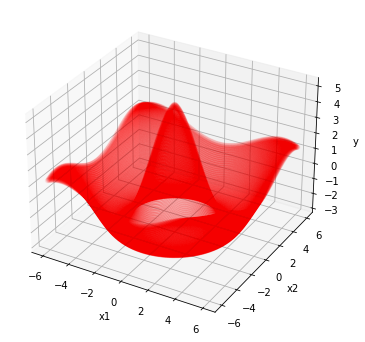

In [13]:
def get_mdn_data(n_train=100, x_min=0, x_max=1):
    x1 = np.linspace(x_min, x_max, n_train).reshape(-1,1)
    x2 = np.linspace(x_min, x_max, n_train).reshape(-1,1)
    x1, x2 = np.meshgrid(x1, x2)
    x_train = np.stack([x1, x2], axis=2).reshape(-1,2)
    y_train = 5 * np.cos(math.pi / 2 * np.linalg.norm(x_train / 2, axis=1)) * np.exp(-math.pi / 20 * np.linalg.norm(x_train, axis=1))
    y_train = y_train.reshape(-1,1)
    return x_train, y_train

x_train, y_train = get_mdn_data(200, -6, 6)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(x_train[:,0], x_train[:,1], y_train, c='r', alpha =0.04)


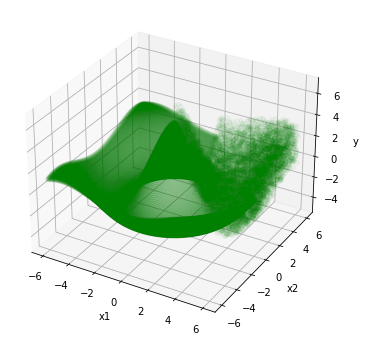

In [24]:
first_quad_idx = []
for idx, i in enumerate(x_train):
    if i[0] > 0 and i[1] > 0 :
        first_quad_idx.append(idx)
        
for idx in (first_quad_idx):
    noise = np.random.uniform(-2,2)
    y_train[idx] += noise
y_train = y_train.reshape(-1,1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(x_train[:,0], x_train[:,1], y_train, c='g', alpha =0.04)

In [17]:
def gmm_forward(pi,mu,sigma,data):
    """
    pi: [N x K]
    mu: [N x K x Y]
    sigma: [N x K x Y]
    data: [N x Y]
    """
    data_usq = torch.unsqueeze(data,dim=1) # [N x 1 x Y]
    data_exp = data_usq.expand_as(sigma) # [N x K x Y]
    probs = (1.0 / math.sqrt(2*math.pi)) * torch.exp(-0.5 * ((data_exp-mu)/sigma)**2) / sigma # [N x K x Y]
    probs_prod = torch.prod(probs,2) # [N x K]
    prob = torch.sum(probs_prod*pi,dim=1) # [N]
    nll = -torch.log(prob) # [N] 
    out = {'data_usq':data_usq,'data_exp':data_exp,
           'probs':probs,'probs_prod':probs_prod,'prob':prob,'nll':nll}
    return out
    
def gmm_sample(pi,mu,sigma):
    """
    pi: [N x K]
    mu: [N x K x Y]
    sigma: [N x K x Y]
    """
    categorical = Distribution.Categorical(pi)
    mixture_list = list(categorical.sample().data)
    _N,_D = sigma.size(0),sigma.size(2)
    eps = Variable(torch.empty(_N,_D).normal_()).to(device) # [N x Y]
    sample = torch.empty_like(eps) # [N x Y]
    for i_idx, mixture_idx in enumerate(mixture_list):
        mu_i,sigma_i = mu[i_idx,mixture_idx],sigma[i_idx,mixture_idx]
        sample[i_idx] = eps[i_idx].mul(sigma_i).add(mu_i)
    return sample # [N x Y]

def get_uncertainty(pi, mu, sigma):
    pi = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_expand = pi.expand_as(sigma) # [N x K x Y]
    mu_avg = torch.sum(torch.mul(pi_expand, mu), dim=1).unsqueeze(1) # [N x 1 x Y]
    mu_expand = mu_avg.expand_as(mu) # [N x K x Y]
    mu_diff = torch.square(mu - mu_expand) # [N x K x Y]
    epis_unct = torch.sum(torch.mul(pi_expand,mu_diff), dim=1) # [N x Y]
    alea_unct = torch.sum(torch.mul(pi_expand,sigma), dim=1)  # [N x Y]
    epis_unct,alea_unct = torch.sqrt(epis_unct),torch.sqrt(alea_unct)
    return epis_unct, alea_unct

In [18]:
def mlp(i_dim=2, h_dims=[256, 256], actv=nn.Tanh()):
    layers = []
    layers.append(nn.Linear(i_dim,h_dims[0]))
    layers.append(actv)
    for idx, hdim in enumerate(h_dims):
        if idx < len(h_dims)-1:
            layers.append(nn.Linear(hdim,h_dims[idx+1]))
            layers.append(actv)
    return nn.Sequential(*layers)

class MixtureDensityNet(nn.Module):
    def __init__(self, x_dim=2, y_dim=1, h_dims=[256, 256], actv=nn.Tanh(), k=10):
        super(MixtureDensityNet, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dims = h_dims
        self.actv = actv 
        self.k = k
        self.net = mlp(self.x_dim, self.h_dims, self.actv)
        self.pi = nn.Linear(self.h_dims[-1], self.k)
        self.mu = nn.Linear(self.h_dims[-1], self.y_dim * self.k)
        self.sigma = nn.Linear(self.h_dims[-1], self.y_dim * self.k)

    def forward(self,x):
        x = self.net(x) 
        pi_logit = self.pi(x)
        pi = torch.softmax(pi_logit, dim=1)
        mu = self.mu(x) # [N x YK]
        mu = torch.reshape(mu, (-1, self.k, self.y_dim)) # [N x K x Y]
        sigma = self.sigma(x) # [N x YK]
        sigma = torch.reshape(sigma, (-1, self.k, self.y_dim)) # [N x K x Y]
        sigma = torch.exp(sigma)
        return pi, mu, sigma

    def update(self, x_train, y_train, MAX_ITER=1e4, BATCH_SIZE=64, lr=1e-3):
        x_train = torch.Tensor(x_train).to(device)
        y_train = torch.Tensor(y_train).to(device)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=1e-3)
        for n_iter in range(int(MAX_ITER)):
            self.train()
            r_idx = np.random.permutation(int(x_train.shape[0]))[:BATCH_SIZE]
            x_batch,y_batch = x_train[r_idx],y_train[r_idx]
            # Update
            self.optim.zero_grad()
            pi_batch,mu_batch,sigma_batch = self.forward(x_batch)
            gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
            loss = torch.mean(gmm_out['nll'])
            loss.backward()
            self.optim.step()

            if (n_iter+1) % 1000 == 0:
                print("[{} / {}] Clear".format(n_iter+1, MAX_ITER))

In [19]:
MDN = MixtureDensityNet().to(device)
MDN.update(x_train, y_train, MAX_ITER=100000, BATCH_SIZE=64, lr=1e-4)

[1000 / 100000] Clear
[2000 / 100000] Clear
[3000 / 100000] Clear
[4000 / 100000] Clear
[5000 / 100000] Clear
[6000 / 100000] Clear
[7000 / 100000] Clear
[8000 / 100000] Clear
[9000 / 100000] Clear
[10000 / 100000] Clear
[11000 / 100000] Clear
[12000 / 100000] Clear
[13000 / 100000] Clear
[14000 / 100000] Clear
[15000 / 100000] Clear
[16000 / 100000] Clear
[17000 / 100000] Clear
[18000 / 100000] Clear
[19000 / 100000] Clear
[20000 / 100000] Clear
[21000 / 100000] Clear
[22000 / 100000] Clear
[23000 / 100000] Clear
[24000 / 100000] Clear
[25000 / 100000] Clear
[26000 / 100000] Clear
[27000 / 100000] Clear
[28000 / 100000] Clear
[29000 / 100000] Clear
[30000 / 100000] Clear
[31000 / 100000] Clear
[32000 / 100000] Clear
[33000 / 100000] Clear
[34000 / 100000] Clear
[35000 / 100000] Clear
[36000 / 100000] Clear
[37000 / 100000] Clear
[38000 / 100000] Clear
[39000 / 100000] Clear
[40000 / 100000] Clear
[41000 / 100000] Clear
[42000 / 100000] Clear
[43000 / 100000] Clear
[44000 / 100000] Cle

In [20]:
MDN.eval()
x_train, y_train = get_mdn_data(200, -6, 6)
x_test, y_test = get_mdn_data(200, -6, 6)
pi, mu, sigma = MDN(torch.FloatTensor(x_test).to(device))
pred = gmm_sample(pi, mu, sigma)
pred = pred.detach().cpu().numpy()

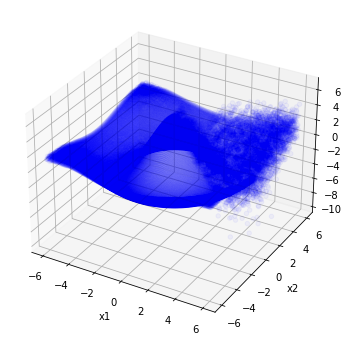

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('')
# ax.scatter(x_train[:,0], x_train[:,1], y_train, c='r', alpha =0.04)
ax.scatter(x_test[:,0], x_test[:,1], pred, c='b', alpha=0.04)

In [27]:
epis_unct, alea_unct = get_uncertainty(pi,mu,sigma)
epis_unct = epis_unct.detach().cpu().numpy()
alea_unct = alea_unct.detach().cpu().numpy()

In [28]:
graph_x1 = np.linspace(-6, 6, 200)
graph_x2 = np.linspace(-6, 6, 200)
graph_x1, graph_x2 = np.meshgrid(graph_x1, graph_x2)
graph_x1x2 = np.stack([graph_x1, graph_x2], axis=2).reshape(-1,2)

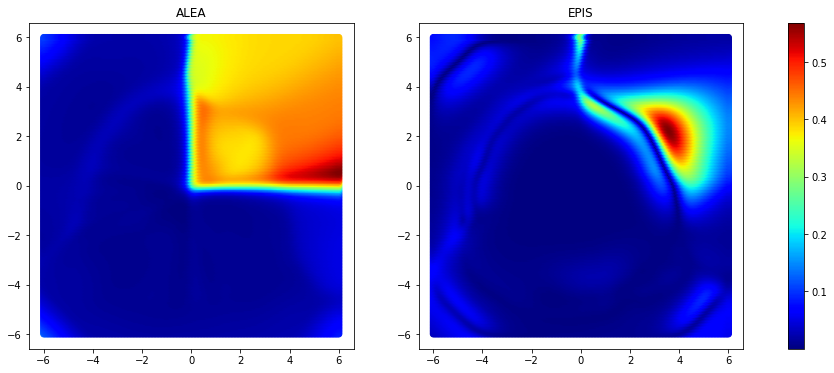

In [29]:
fig, axes = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
for idx, ax in enumerate(axes.flat):
    if idx == 0:
        graph = ax.scatter(graph_x1x2[:,0], graph_x1x2[:,1], c=alea_unct, cmap='jet')
        ax.set_title('ALEA')
    else:
        graph = ax.scatter(graph_x1x2[:,0], graph_x1x2[:,1], c=epis_unct, cmap='jet')
        ax.set_title('EPIS')
fig.colorbar(graph, ax=axes.ravel().tolist())
plt.show()